# Data Formating Script
In this script, we will combine the temperature data and the fire data into a single dataset and extract the relationship between the two factors. 

In [1]:
# Import libraries and initialisation

import os
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d # Linear interpolation method
from scipy.stats import linregress # For linear regression analysis
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import MSTL

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Plotting autocorrelation and partial autocorrelation
import seaborn as sns

# Set the style for seaborn
sns.set_theme(context="notebook", style="darkgrid", palette = "flare")
palette = sns.color_palette("flare", as_cmap=False)

In [2]:
# Initial data structuring

data_path = os.path.join(os.getcwd(), 'Data Sets')
temp_data = pd.read_csv(os.path.join(data_path, 'Temp_data.csv'))
fire_data = pd.read_csv(os.path.join(data_path, 'Fire_data.csv'))

# Only extract data from the 4th row onwards for temp data
temp_data = temp_data.iloc[3:, :2]
# Add column headings
temp_data.columns = ['DateTime', 'MeanTemp']
# Convert column 1 to datetime format
temp_data['DateTime'] = pd.to_datetime(temp_data['DateTime'])
temp_data['MeanTemp'] = pd.to_numeric(temp_data['MeanTemp'], errors='coerce')

# Copy the fire data and using the date, add a new column with temperature data from temp_data
df = fire_data.copy()
# Combine DateOfCall, TimeOfCall into a single DateTime column
df['DateTime'] = pd.to_datetime(df['DateOfCall'] + ' ' + df['TimeOfCall'])
# Remove the original DateOfCall and TimeOfCall columns, plus the CalYear and HourOfCall columns
df = df.drop(columns=['DateOfCall', 'TimeOfCall', 'CalYear', 'HourOfCall'])

print(temp_data.head())
print("=" * 50)
print(df.head())

             DateTime  MeanTemp
3 2019-01-01 01:00:00       7.0
4 2019-01-01 02:00:00       6.6
5 2019-01-01 03:00:00       5.7
6 2019-01-01 04:00:00       5.0
7 2019-01-01 05:00:00       4.6
    IncidentNumber    IncidentGroup        StopCodeDescription  \
0  000006-01012019  Special Service            Special Service   
1  000019-01012019             Fire             Secondary Fire   
2  000020-01012019      False Alarm  False alarm - Good intent   
3  000021-01012019      False Alarm                        AFA   
4  000024-01012019  Special Service            Special Service   

  SpecialServiceType PropertyCategory  \
0       Lift Release         Dwelling   
1                NaN          Outdoor   
2                NaN          Outdoor   
3                NaN         Dwelling   
4       Lift Release         Dwelling   

                                        PropertyType  \
0  Purpose Built Flats/Maisonettes - 4 to 9 storeys    
1                                        Tree scrub 

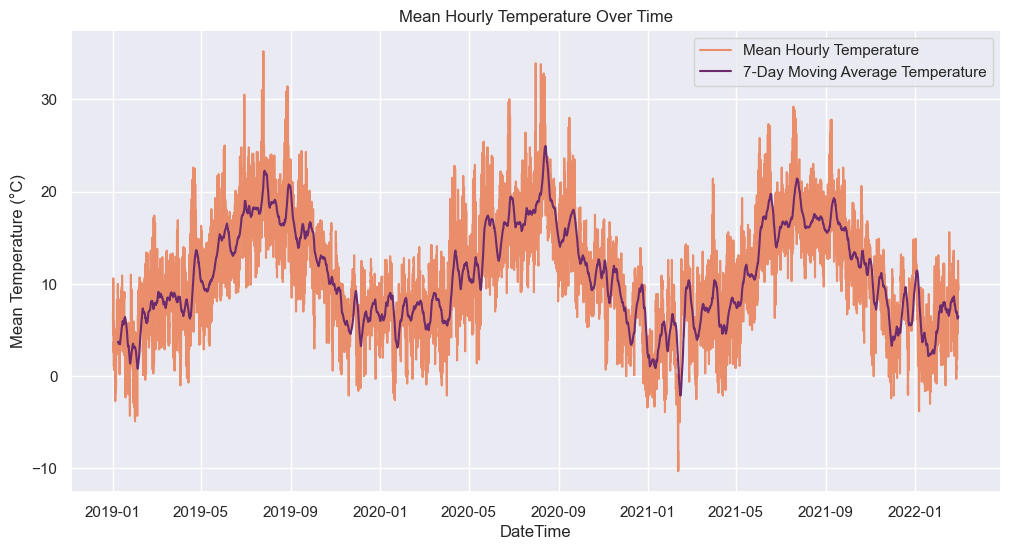

In [3]:
# Plot the temperature data

plots_path = os.path.join(os.getcwd(), 'Plots', 'Temp_fire_relationship')
rolling_window = 24 * 7 # 7 days rolling window for moving average

plt.figure(figsize=(12, 6))
color1, color2 = palette[0], palette[-1]  # Select colors from either end of the palette

plt.plot(temp_data['DateTime'], temp_data['MeanTemp'], label='Mean Hourly Temperature', color = color1)
# Add moving average filter for easier inspection of trends
temp_data['MeanTemp_MA'] = temp_data['MeanTemp'].rolling(window=rolling_window).mean()
plt.plot(temp_data['DateTime'], temp_data['MeanTemp_MA'], label='7-Day Moving Average Temperature', color = color2)
plt.title('Mean Hourly Temperature Over Time')
plt.xlabel('DateTime')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.savefig(os.path.join(plots_path, 'Mean_Temperature_Over_Time.png'), bbox_inches='tight')
plt.show()

Using linear interpolation, we will combine the data sets and determine whether a correlation exists between the temperature and the frequency of fires.

In [4]:
# Add a new column to df for the temperature
df['MeanTemp'] = np.nan

# Interpolate the temperature data to fill in the missing values in df
interp_func = interp1d(temp_data['DateTime'].astype(np.int64), temp_data['MeanTemp'], bounds_error=False, fill_value='extrapolate')
df['MeanTemp'] = interp_func(df['DateTime'].astype(np.int64))

# Print the combined data, just showing the date and temperature columns. Print first 50 rows
print(df[['DateTime', 'MeanTemp']].head(50))

# Save the combined data to a new CSV file
combined_data_path = os.path.join(data_path, 'Combined_data.csv')

try:
    df.to_csv(combined_data_path, index=False)
    print(f"Combined data saved to {combined_data_path}")
except Exception as e:
    print(f"Error saving combined data: {e}")

              DateTime  MeanTemp
0  2019-01-01 00:01:45  7.388333
1  2019-01-01 00:04:33  7.369667
2  2019-01-01 00:04:39  7.369000
3  2019-01-01 00:04:44  7.368444
4  2019-01-01 00:05:00  7.366667
5  2019-01-01 00:05:33  7.363000
6  2019-01-01 00:07:20  7.351111
7  2019-01-01 00:11:22  7.324222
8  2019-01-01 00:11:32  7.323111
9  2019-01-01 00:12:49  7.314556
10 2019-01-01 00:13:18  7.311333
11 2019-01-01 00:13:53  7.307444
12 2019-01-01 00:14:49  7.301222
13 2019-01-01 00:15:23  7.297444
14 2019-01-01 00:17:10  7.285556
15 2019-01-01 00:18:09  7.279000
16 2019-01-01 00:22:43  7.248556
17 2019-01-01 00:23:05  7.246111
18 2019-01-01 00:26:47  7.221444
19 2019-01-01 00:27:02  7.219778
20 2019-01-01 00:29:28  7.203556
21 2019-01-01 00:29:42  7.202000
22 2019-01-01 00:30:11  7.198778
23 2019-01-01 00:34:01  7.173222
24 2019-01-01 00:34:25  7.170556
25 2019-01-01 00:35:27  7.163667
26 2019-01-01 00:35:45  7.161667
27 2019-01-01 00:36:43  7.155222
28 2019-01-01 00:37:05  7.152778
29 2019-01

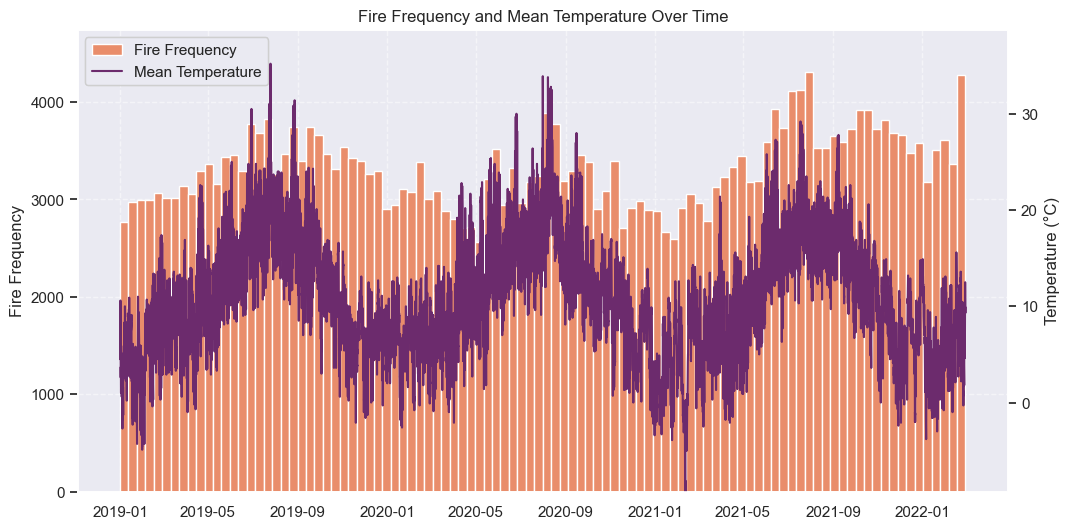

In [5]:
# Plot histogram to show frequency of fires over time and add max temperature
plt.figure(figsize=(12, 6))
color1, color2 = palette[0], palette[-1]  # Select colors from either end of the palette

# Create the main axis for fire frequency
ax_fire = plt.gca()
hist_plot = ax_fire.hist(df['DateTime'], bins=100, label='Fire Frequency', color=color1)
ax_fire.set_ylabel('Fire Frequency')
ax_fire.grid(True, which='both', linestyle='--', alpha=0.5)

# Create the secondary axis for temperature
ax_temp = ax_fire.twinx()
line_plot, = ax_temp.plot(temp_data['DateTime'], temp_data['MeanTemp'], label='Mean Temperature', color=color2)
ax_temp.set_ylabel('Temperature (°C)')

# Align y-axes limits based on a scaling factor
fire_min, fire_max = 0, max(hist_plot[0]) * 1.1  # Fire frequency axis limits
temp_min, temp_max = temp_data['MeanTemp'].min() * 0.9, temp_data['MeanTemp'].max() * 1.1  # Temperature axis limits

# Define the scaling factor to align the axes
scaling_factor = (temp_max - temp_min) / (fire_max - fire_min)

# Set the limits for both axes
ax_fire.set_ylim(fire_min, fire_max)
ax_temp.set_ylim(fire_min * scaling_factor + temp_min, fire_max * scaling_factor + temp_min)

# Add shared grid
ax_fire.grid(True, which='both', linestyle='--', alpha=0.5)
ax_temp.grid(False)  # Disable grid on the secondary axis to avoid duplication

# Combine legends
plt.title('Fire Frequency and Mean Temperature Over Time')
plt.xlabel('DateTime')
combined_legend = ax_fire.legend([hist_plot[2], line_plot], ['Fire Frequency', 'Mean Temperature'], loc='upper left')
ax_fire.add_artist(combined_legend)

# Save and show the plot
plt.savefig(os.path.join(plots_path, 'Fire_Frequency_and_Mean_Temperature_Over_Time.png'), bbox_inches='tight')
plt.show()

1155  unique dates found in the combined data.
         Date  FireCount  MaxTemp   AvgTemp
0  2019-01-01        304     10.6  6.852174
1  2019-01-02        231      5.9  3.725000
2  2019-01-03        234      5.1  1.979167
3  2019-01-04        234      3.0 -0.516667
4  2019-01-05        249      4.5  1.929167


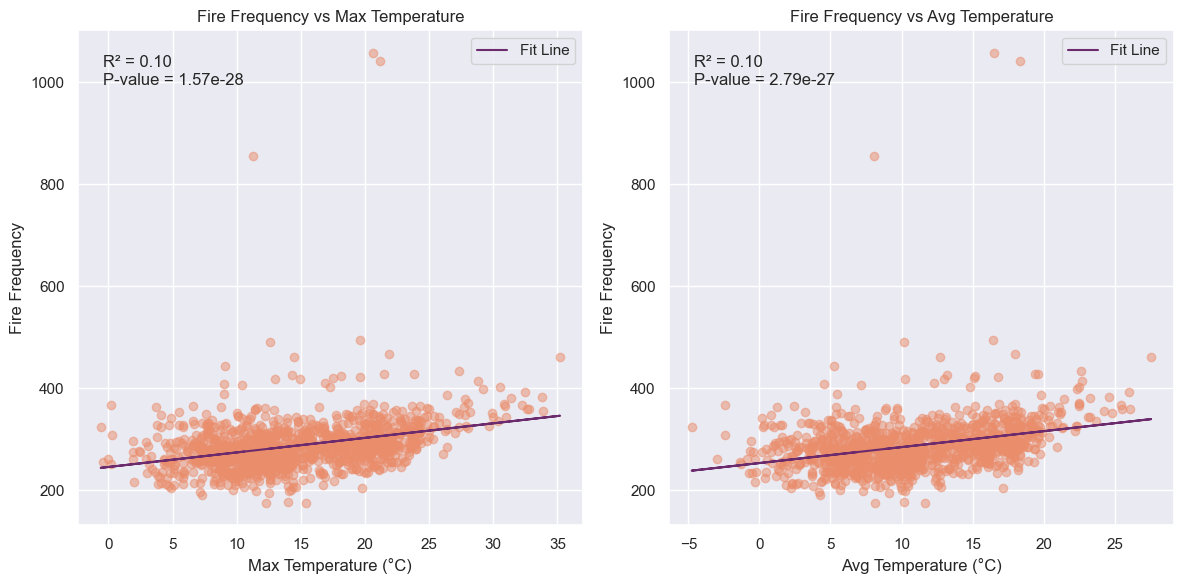

In [6]:
# Plot the frequency of fires given the maximum temperature on each day, use PPMC to determine correlation

# Create empty DataFrame to hold the max temperature for each day
temp_fire_df = pd.DataFrame(columns=['Date', 'MaxTemp', 'AvgTemp', 'FireCount'])

# Get unique dates from fire data and group by date to count fires
fire_by_date = df.groupby(df['DateTime'].dt.date).size().reset_index(name='FireCount')
fire_by_date.columns = ['Date', 'FireCount']

# Get temperature statistics by date
temp_by_date = temp_data.groupby(temp_data['DateTime'].dt.date)['MeanTemp'].agg(['max', 'mean']).reset_index()
temp_by_date.columns = ['Date', 'MaxTemp', 'AvgTemp']

# Merge the two dataframes
temp_fire_df = pd.merge(fire_by_date, temp_by_date, on='Date', how='outer').fillna(0)

print(len(temp_fire_df), " unique dates found in the combined data.")
print(temp_fire_df.head())

# Plot the frequency of fires given the maximum temperature on each day alongside frquency of fires given the mean temperature of each day

fig = plt.figure(figsize=(12, 6))
ax1, ax2 = fig.subplots(1, 2)

color1, color2 = palette[0], palette[-1]  # Select colors from either end of the palette

# Plot for maximum temperature
ax1.scatter(temp_fire_df['MaxTemp'], temp_fire_df['FireCount'], alpha=0.5, color = color1)
ax1.set_title('Fire Frequency vs Max Temperature')
ax1.set_xlabel('Max Temperature (°C)')
ax1.set_ylabel('Fire Frequency')
# Add linear regssion line
slope, intercept, r_value, p_value, std_err = linregress(temp_fire_df['MaxTemp'], temp_fire_df['FireCount'])
ax1.plot(temp_fire_df['MaxTemp'], intercept + slope * temp_fire_df['MaxTemp'], color=color2, label='Fit Line')
ax1.legend()
# Add p value and r-squared to the plot
ax1.text(0.05, 0.95, f'R² = {r_value**2:.2f}\nP-value = {p_value:.2e}', transform=ax1.transAxes, fontsize=12, verticalalignment='top')

# Plot for average temperature
ax2.scatter(temp_fire_df['AvgTemp'], temp_fire_df['FireCount'], alpha=0.5, color = color1)
ax2.set_title('Fire Frequency vs Avg Temperature')
ax2.set_xlabel('Avg Temperature (°C)')
ax2.set_ylabel('Fire Frequency')
# Add linear regression line
slope, intercept, r_value, p_value, std_err = linregress(temp_fire_df['AvgTemp'], temp_fire_df['FireCount'])
ax2.plot(temp_fire_df['AvgTemp'], intercept + slope * temp_fire_df['AvgTemp'], color=color2, label='Fit Line')
ax2.legend()
# Add p value and r-squared to the plot
ax2.text(0.05, 0.95, f'R² = {r_value**2:.2f}\nP-value = {p_value:.2e}', transform=ax2.transAxes, fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.savefig(os.path.join(plots_path, 'Fire_Frequency_vs_Temperature.png'), bbox_inches='tight')
plt.show()

The graphs above show a statistically significant relationship between the temperature and the frequency of fires, but a weak positive correlation, indicating that temperature may not be a leading cause, but is certainly a contributing factor. This seems reasonable: whilst the broad trend of the temperature data follows a sinusoidal curve that tracks with the frequency of fires, the temperature data itself is extremely noisy.

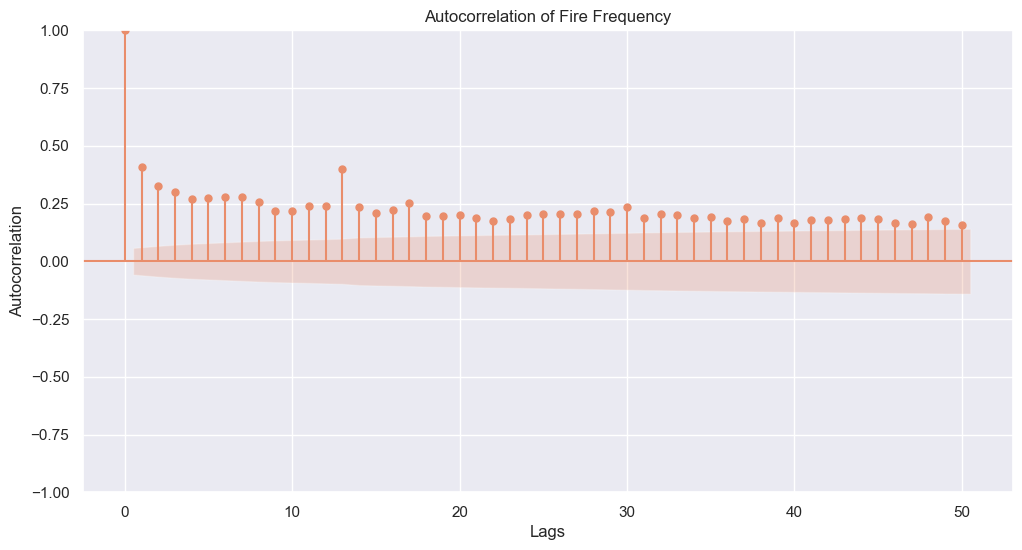

In [7]:
# Investigate autocorrelation in the fire data

plt.figure(figsize=(12, 6))
plot_acf(temp_fire_df['FireCount'], lags=50, ax=plt.gca())
plt.title('Autocorrelation of Fire Frequency')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.savefig(os.path.join(plots_path, 'Autocorrelation_Fire_Frequency.png'), bbox_inches='tight')
plt.show()

The autocorrelation plot above shows no delayed correlation between temperature and number of fires. This is expected given the overlay of fire incidents and temperature in 'Fire Frequency and Mean Temperature over Time'